In [5]:
import numpy as np
import pandas as pd
import random 
import time 
from collections import deque
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import dual_annealing

#### Update: 
##### 1. Run ODE within a discrete-time loop instead 
##### 2. Age-specific feedback parameter

In [3]:
# ------------------------------------------------------------------
# 1.  Data — replace with your own cumulative case matrix
# ------------------------------------------------------------------
cases = pd.read_csv("/Users/boyapeng/Desktop/Dissertation/Aim1/Data/case_count.csv",header=0)

# Extract Date and Gaines, remove if NA
case_df = (
    cases[["Update Date", "Gaines"]]          # keep only the needed cols
         .loc[1:]
         .assign(
             Gaines=lambda d: pd.to_numeric(d["Gaines"], errors="coerce"),
             Date=lambda d: pd.to_datetime(d["Update Date"])
         )
         .dropna(subset=["Gaines"])           # drop rows where Gaines is NaN
         .set_index("Date")                   # set date as index
         .drop(columns="Update Date")         # drop redundant col
         .sort_index()
)

# Prepare the proportion dataframe
prop_path = "/Users/boyapeng/Desktop/Dissertation/Aim1/Data/case_age_prop_ext.csv"
prop_df   = pd.read_csv(prop_path)
prop_df.rename(columns={prop_df.columns[0]: "Date"}, inplace=True)
prop_df[["Prop_0-4", "Prop_5-17", "Prop_18+"]] = prop_df[
    ["Prop_0-4", "Prop_5-17", "Prop_18+"]
].astype(float)
prop_df["Date"] = pd.to_datetime(prop_df["Date"])
prop_df = prop_df.set_index("Date").sort_index()

# Ensure both dataframes cover the same dates
case_aligned = case_df.reindex(prop_df.index)

# Keep only dates where we have a real case count
valid_idx      = case_aligned["Gaines"].notna()   # Boolean mask
case_filtered  = case_aligned.loc[valid_idx]      # drop NaNs
prop_filtered  = prop_df.loc[valid_idx]           # keep matching rows

# Multiply to get age-stratified counts
case_counts = (
    case_filtered["Gaines"].to_numpy().reshape(-1, 1) *
    prop_filtered[["Prop_0-4", "Prop_5-17", "Prop_18+"]].to_numpy()
).round().astype(int).tolist() 
case_counts = np.array(case_counts)

# Time
date = case_df.index.to_series()
ts_cases = ((date - date.iloc[0]).dt.days + date.iloc[0].day).tolist()
ts_cases = np.array(ts_cases)

n_age = 3
n_obs = len(case_counts)

/var/folders/vy/m4l1bmcs7xd4nmd991yq7qkr0000gn/T/ipykernel_45611/1468431833.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Date=lambda d: pd.to_datetime(d["Update Date"])


In [6]:
N_raw = np.array([2341, 6500, 13682], dtype=int)   # population
V_raw = np.array([1988, 4536, 11616], dtype=int)   # one-dose total
E_raw = np.zeros(n_age, dtype=int)                 # exposed
I_raw = np.array([0, 1, 0], dtype=int)             # infectious

# Initialize y0 vector (length 10*n_age)
y0 = np.zeros(10 * n_age)

# Vaccination rate (daily proportion vaccinated)
v = 0.003

# Vaccine efficacy (leakey)
epsA = 1  
epsL = 0.97

# Exposed to infectious rate
sigma = float(np.random.gamma(shape=10, scale=1/80))

# Infectious to recovered rate
gamma1 = 1/3

# Underreporting rate
rep = 0.9

# Contact matrix (flattened row-major order) ##time-varying
C = np.array([
    1.4101, 2.5282, 4.9100,
    0.9290,11.0091, 6.0771,
    0.4884, 1.6387, 8.8461
])
C_flat = C.ravel(order="C")  

x_r = [v, epsA, epsL, sigma, gamma1, rep] + C.flatten(order='C').tolist()
x_i = [n_age] + N_raw.tolist() + V_raw.tolist() + E_raw.tolist() + I_raw.tolist()

In [96]:
# ------------------------------------------------------------------
# 2.  Deterministic SEIRHD ODE
# ------------------------------------------------------------------
def seirhd_discrete(params, x_r, x_i, days=160, dt=1.0, xwin=1, 
                    toggle_short=1, toggle_long=1, verbose=False):
    """
    Discrete-time SEIRHD model with behavioral feedback.
    
    Parameters
    ----------
    params : array-like
        [β₀, β₁, ..., β_{n_age-1}, con, dc, Dc]
    x_r : array
        [v, epsA, epsL, sigma, gamma1, rep, *Cflat*]
    x_i : array
        [n_age, N_pop_0, …, N_pop_{n_age−1}]
    days : int
        Total simulation days
    dt : float
        Time step (days)
    xwin : int
        Short-term behavior window length (days)
    """

    n_age = int(x_i[0])
    N_pop = np.asarray(x_i[1:1 + n_age], dtype=float)
    beta  = np.asarray(params[:n_age], dtype=float)
    con   = float(params[n_age])
    dc = np.array(params[n_age + 1 : n_age + 1 + n_age], dtype=float)
    Dc    = float(params[n_age + 1 + n_age])
    #g    = float(params[n_age + 2 + n_age])
    
    v, epsA, epsL, sigma, gamma1, rep = x_r[:6]
    Cmat = np.reshape(x_r[6:], (n_age, n_age))

    # Initialize compartments (same as build_y0)
    y = build_y0(con).copy()

    # For rolling short-term memory (sum of new infections in past xwin days)
    window = deque([0.0] * xwin, maxlen=xwin)

    # Arrays to store cumulative cases over time (for comparison)
    n_obs = int(days / dt)
    cum_cases_out = np.zeros((n_obs, n_age))

    for t in range(n_obs):
        dydt = np.zeros_like(y)

        # --- total infection and cumulative ---
        E_total = sum(max(y[i*9 + 5], 0.0) for i in range(n_age))
        C_total = sum(max(y[i*9 + 8], 0.0) for i in range(n_age))
        new_inf = sigma * E_total
        window.append(new_inf)
        short_sum = sum(window)
        cum_inf = C_total

        # --- behavioral feedback per age --- 
        ####reported -rep v.s. time
        ####function between infection and hosp/death
        ####x days
        f_t_age = np.zeros(n_age)
        for i in range(n_age):
            f_t_age[i] = 1.0 / (1.0 + toggle_short * dc[i] * short_sum + toggle_long * Dc * cum_inf)

        # Dynamics for each age group
        for i in range(n_age):
            idx = i * 9
            S1, VS1, VR1, S2, V2, E, I, R, C = y[idx : idx + 9]

            lam_i = 0.0
            for j in range(n_age):
                jdx = j * 9
                Ij  = max(y[jdx + 6], 0.0)
                Nj  = N_pop[j] - y[jdx + 3] - y[jdx + 4]
                lam_i += Cmat[i, j] * Ij / Nj

            lam   = beta[i] * con * f_t_age[i] * lam_i 
            v_eff = v if i == 0 else 0.0

            dS1 = -lam * S1 - v_eff * S1
            dVS1 = (1 - epsA) * v_eff * S1 - lam * VS1
            dVR1 = epsA * v_eff * S1 - lam * (1 - epsL) * VR1
            dS2 = -v_eff * S2
            dV2 = v_eff * S2
            dE = lam * (S1 + VS1 + (1 - epsL) * VR1) - sigma * E
            dI = sigma * E - gamma1 * I
            dR = gamma1 * I
            dC = sigma * E

            # Euler update (can refine later with RK2)
            y[idx + 0] += dS1 * dt
            y[idx + 1] += dVS1 * dt
            y[idx + 2] += dVR1 * dt
            y[idx + 3] += dS2 * dt
            y[idx + 4] += dV2 * dt
            y[idx + 5] += dE * dt
            y[idx + 6] += dI * dt
            y[idx + 7] += dR * dt
            y[idx + 8] += dC * dt

        cum_cases_out[t, :] = [y[9*i + 8] for i in range(n_age)]

        if verbose and t % 7 == 0:
            print(f"t={t:3d} short={short_sum:.2e} long={cum_inf:.2e} "
                  f"dc∈[{dc.min():.2e},{dc.max():.2e}] Dc={Dc:.2e} "
                  f"f_t∈[{f_t_age.min():.3f},{f_t_age.max():.3f}]")

    return cum_cases_out

def build_y0(con):

    y0 = np.zeros(9 * n_age, dtype=float)

    S_base = N_raw - V_raw - E_raw - I_raw       # susceptibles (all flavours)

    for j in range(n_age):
        idx = 9 * j
        y0[idx + 0] = S_base[j]         * con
        y0[idx + 1] = (1 - epsA) * V_raw[j] * con
        y0[idx + 2] =      epsA  * V_raw[j] * con

        y0[idx + 3] = S_base[j]         * (1 - con)
        y0[idx + 4] = V_raw[j]          * (1 - con)

        y0[idx + 5] = E_raw[j]                       # E
        y0[idx + 6] = I_raw[j]                       # I
        y0[idx + 7] = 0.0                            # R
        y0[idx + 8] = I_raw[j]                       # cumulative cases
        
    return y0
    

In [92]:
params = best
n_age = int(x_i[0])
β_vec = np.array(params[:n_age], dtype=float)
con   = float(params[n_age])
t0    = float(params[n_age + 1])
dc_vec = np.array(params[n_age + 2 : n_age + 2 + n_age], dtype=float)
Dc    = float(params[n_age + 2 + n_age])

# combine into one vector for seirhd_discrete
theta = np.concatenate([β_vec, [con], dc_vec, [Dc]])

days = ts_cases[-1]
idx = (np.array(ts_cases) - t0).astype(int)

results = seirhd_discrete(theta, x_r, x_i, days=days, dt=1.0, xwin=7, verbose=True)

t=  0 short=0.00e+00 long=1.00e+00 dc∈[1.68e-01,6.12e-01] Dc=2.52e-02 f_t∈[0.975,0.975]
t=  7 short=1.59e+01 long=1.31e+01 dc∈[1.68e-01,6.12e-01] Dc=2.52e-02 f_t∈[0.090,0.250]
t= 14 short=3.53e+01 long=4.66e+01 dc∈[1.68e-01,6.12e-01] Dc=2.52e-02 f_t∈[0.042,0.123]
t= 21 short=4.06e+01 long=8.69e+01 dc∈[1.68e-01,6.12e-01] Dc=2.52e-02 f_t∈[0.036,0.100]
t= 28 short=3.99e+01 long=1.27e+02 dc∈[1.68e-01,6.12e-01] Dc=2.52e-02 f_t∈[0.035,0.092]
t= 35 short=3.70e+01 long=1.65e+02 dc∈[1.68e-01,6.12e-01] Dc=2.52e-02 f_t∈[0.036,0.088]
t= 42 short=3.36e+01 long=1.99e+02 dc∈[1.68e-01,6.12e-01] Dc=2.52e-02 f_t∈[0.038,0.086]
t= 49 short=3.02e+01 long=2.29e+02 dc∈[1.68e-01,6.12e-01] Dc=2.52e-02 f_t∈[0.040,0.084]
t= 56 short=2.71e+01 long=2.57e+02 dc∈[1.68e-01,6.12e-01] Dc=2.52e-02 f_t∈[0.042,0.083]
t= 63 short=2.42e+01 long=2.82e+02 dc∈[1.68e-01,6.12e-01] Dc=2.52e-02 f_t∈[0.044,0.082]
t= 70 short=2.18e+01 long=3.04e+02 dc∈[1.68e-01,6.12e-01] Dc=2.52e-02 f_t∈[0.046,0.081]
t= 77 short=1.96e+01 long=3.23e+

In [98]:
def predict_cum(params):
    n_age = int(x_i[0])
    β_vec = np.array(params[:n_age], dtype=float)
    con   = float(params[n_age])
    t0    = float(params[n_age + 1])
    dc_vec = np.array(params[n_age + 2 : n_age + 2 + n_age], dtype=float)
    Dc    = float(params[n_age + 2 + n_age])
    #g    = float(params[n_age + 3 + n_age])

    # combine into one vector for seirhd_discrete
    theta = np.concatenate([β_vec, [con], dc_vec, [Dc]])

    days = ts_cases[-1]
    idx = (np.array(ts_cases) - t0).astype(int)

    results = seirhd_discrete(theta, x_r, x_i, days=days, dt=1.0, xwin=7)
    pred = results[idx, :]
    return pred
    
def fitness(individual):
    pred = predict_cum(individual)           # your output slice
    resid = pred - case_counts              # same shape
    mse   = (resid**2).mean()               # divide by n_obs * n_age
    return mse   

In [99]:
"""
Simulated Annealing (via SciPy’s dual_annealing) for fitting SEIRHD ODE
parameters to cumulative-case observations.
"""

STATE_PER_AGE = 9      # S1,VS1,VR1,S2,V2,E,I,R,CUM

# ---------- Parameter bounds --------------------------------------------
bounds = [
    (0.1, 10.0),   # β0
    (0.1, 10.0),   # β1
    (0.1, 10.0),   # β2
    (0.01, 1.0),   # con
    (1.0, 28.0),   # t0
    (0.0001, 1.0),   # dc0
    (0.0001, 1.0),   # dc1
    (0.0001, 1.0),   # dc2
    (0.0001, 1.0),   # Dc
    #(0.1, 10.0),   # g
]

# ---------- Simulated annealing fit -------------------------------------
result = dual_annealing(
    fitness,
    bounds=bounds,
    maxiter=650,           # iterations of annealing schedule
    initial_temp=100.0,       # ← try 50-100
    seed=42,
    no_local_search=True,  # set False to enable Powell local search at the end
)

best = result.x.copy(); best[4] = int(round(best[4]))
print("Best θ:", best)
print("Best MSE:", result.fun)


Best θ: [9.90396456e+00 7.82105165e-01 3.08657510e+00 9.04787942e-01
 2.80000000e+01 2.32333535e-01 1.68055424e-01 6.11818382e-01
 2.52004010e-02]
Best MSE: 134.10088691700363


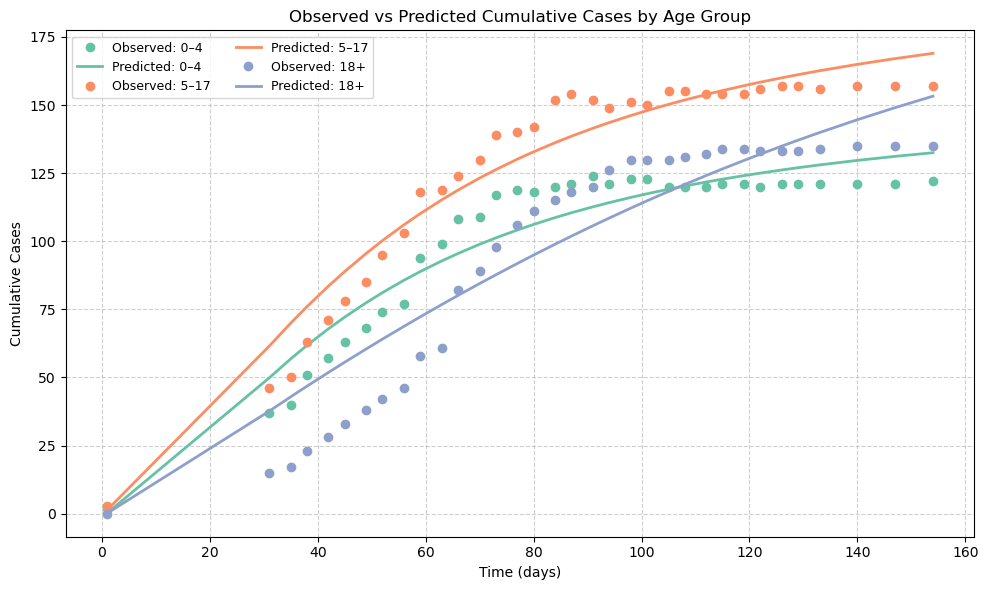

In [30]:
# -------------------------------------------------------------------
# 4.  Plot: predicted vs observed
# -------------------------------------------------------------------
pred_cum = predict_cum(best) 
obs_cum = np.asarray(case_counts, dtype=float)   

t0    = float(best[n_age + 1])
t_eval  = np.array(ts_cases) - t0

age_labels = ['0–4', '5–17', '18+']
colors     = plt.get_cmap('Set2')

plt.figure(figsize=(10, 6))

for k in range(pred_cum.shape[1]):
    # Observed
    plt.plot(t_eval, obs_cum[:, k], 'o',
             markersize=6, color=colors(k),
             label=f'Observed: {age_labels[k]}')
    # Predicted
    plt.plot(t_eval, pred_cum[:, k], '-',
             linewidth=2, color=colors(k),
             label=f'Predicted: {age_labels[k]}')

plt.xlabel('Time (days)')
plt.ylabel('Cumulative Cases')
plt.title('Observed vs Predicted Cumulative Cases by Age Group')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

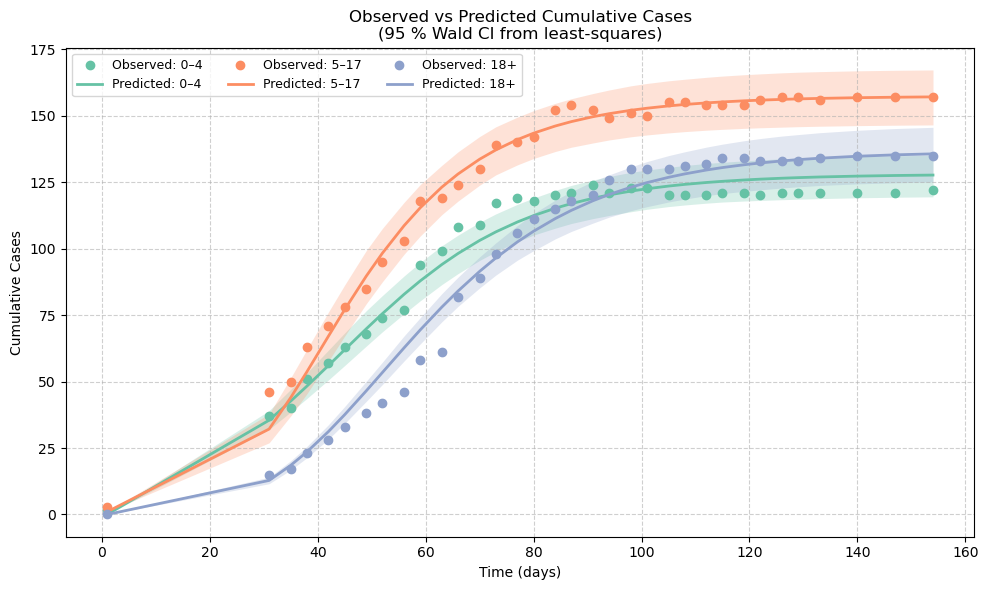


Wald 95 % parameter CIs:
 β0:   6.2322  [  5.3285,   7.1359]
 β1:   0.2056  [  0.1852,   0.2259]
 β2:   0.2044  [  0.1898,   0.2191]
con:   0.0663  [  0.0614,   0.0712]
 t0:  28.0000  [ 27.9951,  28.0049]


In [72]:
# Try a non-linear least-squares method
from scipy.optimize import least_squares
from scipy.stats import t, multivariate_normal as mvn

# ---------------------------------------------------------------
# Non-linear Least–squares refinement (nlinfit analogue)
# Re-optimises in case GA is off by a hair.
# Returns J, the sensitivity of each residual to each parameter
# ---------------------------------------------------------------

#Taylor’s power law (around beta/2)
eps          = 1e-6                       # avoid divide-by-zero
#weight  = 1.0 / np.sqrt(obs_cum + eps)   # (n_obs, n_age)
weight  = 1.0 / (obs_cum/rep + eps)**1.1

#def resid(theta_vec):
#    return (predict_cum(theta_vec) - obs_cum).ravel()   # flatten to 1-D
def resid_wls(theta_vec):
    pred = predict_cum(theta_vec)         # (n_obs, n_age)
    wr   = (pred - obs_cum) * weight # weight each residual
    return wr.ravel()                     # (n_obs*n_age,)

#res = least_squares(resid, best_par, method="trf", jac="2-point",
#                    bounds=([0,0,0,0.01,1], [6,6,6,0.99,28]))  # example bounds
res = least_squares(
        resid_wls,
        x0      = best,
        bounds  = ([0,0,0,0.01, 1], [10,10,10,0.99, ts_cases[0]-1e-3]),
        method  = "trf",
        jac     = "2-point"
)

theta_hat = best
J         = res.jac                 # (N_obs*n_age) × p
N, p      = J.shape
sse       = np.sum(res.fun**2)
sigma2    = sse / (N - p)         #residual variance

# Wald (nlparci-style) covariance
cov_theta = sigma2 * np.linalg.inv(J.T @ J)

# ---------------------------------------------------------------
# 3.  Parameter draw cloud (1 000 draws from N(θ̂, Σ̂))
# ---------------------------------------------------------------
n_draws   = 1000
rng       = np.random.default_rng(42)
theta_draws = rng.multivariate_normal(theta_hat, cov_theta, size=n_draws)
theta_draws[:,4] = np.clip(theta_draws[:,4], 1, 28) # Clip / reflect** t0 into range

pred_stack = np.stack([predict_cum(th) for th in theta_draws])  # (n_draws,n_obs,n_age)

pred_mean  = pred_cum   #pred_stack.mean(axis=0)
pred_low   = np.percentile(pred_stack,  2.5, axis=0)
pred_high  = np.percentile(pred_stack, 97.5, axis=0)

# ---------------------------------------------------------------
# 4.  Plot
# ---------------------------------------------------------------
age_labels = ['0–4', '5–17', '18+']
colors     = plt.get_cmap('Set2')

plt.figure(figsize=(10, 6))
for k in range(pred_mean.shape[1]):
    plt.fill_between(t_eval, pred_low[:, k], pred_high[:, k],
                     color=colors(k), alpha=0.25, linewidth=0)
    plt.plot(t_eval, obs_cum[:, k], 'o', markersize=6,
             color=colors(k), label=f'Observed: {age_labels[k]}')
    plt.plot(t_eval, pred_mean[:, k], '-', linewidth=2,
             color=colors(k), label=f'Predicted: {age_labels[k]}')

plt.xlabel('Time (days)')
plt.ylabel('Cumulative Cases')
plt.title('Observed vs Predicted Cumulative Cases\n(95 % Wald CI from least-squares)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 5.  Optional: print parameter CIs
# ---------------------------------------------------------------
alpha = 0.05
tcrit = t.ppf(1 - alpha/2, df=N - p)
ci_lo = theta_hat - tcrit * np.sqrt(np.diag(cov_theta))
ci_hi = theta_hat + tcrit * np.sqrt(np.diag(cov_theta))
param_names = ["β0", "β1", "β2", "con", "t0"]

print("\nWald 95 % parameter CIs:")
for name, lo, est, hi in zip(param_names, ci_lo, theta_hat, ci_hi):
    print(f"{name:>3s}: {est:8.4f}  [{lo:8.4f}, {hi:8.4f}]")

In [73]:
# ---------------------------------------------------------------
# Coverage of the 95 % CI ribbon
# ---------------------------------------------------------------
# pred_low, pred_high : (n_obs, n_age)
# obs_cum             : (n_obs, n_age)

inside_mask = (obs_cum >= pred_low) & (obs_cum <= pred_high)
n_inside    = int(inside_mask.sum())                  # True → 1
n_total     = obs_cum.size                            # n_obs * n_age
coverage    = n_inside / n_total * 100.0

print(f"Observed points inside 95 % CI : {n_inside} / {n_total} "
      f"({coverage:.1f} %)")

Observed points inside 95 % CI : 86 / 102 (84.3 %)


In [74]:
"""
Repeated dual-annealing runs → runtime, MAE, RMSE (mean ± 95 % CI)
"""

import numpy as np
import time
from scipy.optimize import dual_annealing
from math import sqrt

# ----- helper ------------------------------------------------------------
def mae(pred, obs):
    return np.mean(np.abs(pred - obs))

def run_once(seed):
    tic = time.perf_counter()

    res = dual_annealing(
        fitness,
        bounds=bounds,
        maxiter=650,
        initial_temp=75.0,
        no_local_search=True,
        seed=seed,
    )
    best = res.x.copy(); best[4] = int(round(best[4]))

    toc = time.perf_counter()
    pred_cum = predict_cum(best)          # model output at observation times
    rmse = sqrt(fitness(best))

    return {
        "time":  toc - tic,               # seconds
        "mae":   mae(pred_cum, case_counts),
        "rmse":  rmse,
        "conv":  res.message,             # convergence text
        "nfev":  res.nfev,         # total model evaluations
        "nit":   res.nit,          # number of global iterations
    }

def mean_ci_range(values, z=1.96):
    """
    Returns: (mean, lower, upper) using z-score CI.
    """
    vals = np.asarray(values, float)
    n = len(vals)
    mean = np.mean(vals)
    se = np.std(vals, ddof=1) / np.sqrt(n)
    ci_half = z * se
    return mean, mean - ci_half, mean + ci_half

# ----- experiment loop ---------------------------------------------------
N_RUNS = 20
stats  = [run_once(seed) for seed in range(N_RUNS)]

times   = [s["time"] for s in stats]
maes    = [s["mae"]  for s in stats]
rmses   = [s["rmse"] for s in stats]
messages = [s["conv"] for s in stats]
nfevs = [s["nfev"] for s in stats]
nits  = [s["nit"]  for s in stats]

# ----- print summary -----------------------------------------------------
mae_mean, mae_lo, mae_hi = mean_ci_range(maes)
rmse_mean, rmse_lo, rmse_hi = mean_ci_range(rmses)
t_mean, t_lo, t_hi = mean_ci_range(times)
nfev_mean, nfev_lo, nfev_hi = mean_ci_range(nfevs)
nit_mean,  nit_lo,  nit_hi  = mean_ci_range(nits)

print(f"  Runtime: {t_mean:.4g} sec  (95 % CI [{t_lo:.4g}, {t_hi:.4g}])")
print(f"  MAE    : {mae_mean:.4g}    (95 % CI [{mae_lo:.4g}, {mae_hi:.4g}])")
print(f"  RMSE   : {rmse_mean:.4g}    (95 % CI [{rmse_lo:.4g}, {rmse_hi:.4g}])")
print(f"  Model evals : {nfev_mean:.4g}  (95 % CI [{nfev_lo:.4g}, {nfev_hi:.4g}])")
print(f"  Iterations  : {nit_mean:.4g}  (95 % CI [{nit_lo:.4g}, {nit_hi:.4g}])")


  Runtime: 56.92 sec  (95 % CI [55.83, 58.02])
  MAE    : 3.764    (95 % CI [3.762, 3.766])
  RMSE   : 5.072    (95 % CI [5.066, 5.077])
  Model evals : 6501  (95 % CI [6501, 6501])
  Iterations  : 650  (95 % CI [650, 650])


In [ ]:
times_min = np.array(times) / 60.0
t_min_mean, t_min_lo, t_min_hi = mean_ci_range(times_min)
print(f"  Runtime: {t_min_mean:.4g} min  (95 % CI [{t_min_lo:.4g}, {t_min_hi:.4g}])")

  Runtime: 1.217 min  (95 % CI [1.183, 1.251])


ΔMSE over last 10 iterations = 0.00747
Coverage criterion satisfied? True


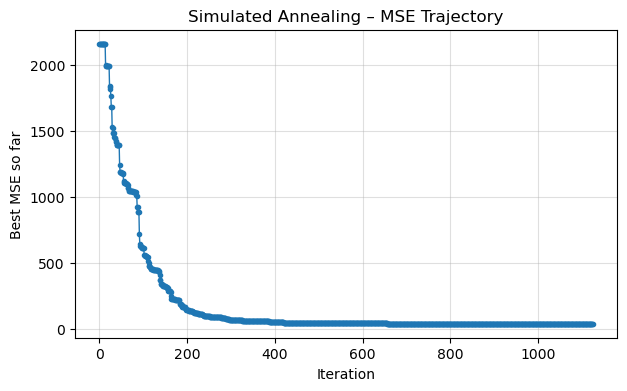

In [64]:
from collections import defaultdict
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Tracker for MSE trajectory
# ---------------------------------------------------------
def make_tracker():
    history = defaultdict(list)

    def callback(x, f, context):
        # f is the best objective value (MSE) at this iteration
        history["mse"].append(f)
    return history, callback

# ---------------------------------------------------------
# 2. Run once and record MSE trajectory
# ---------------------------------------------------------
history, cb = make_tracker()

res = dual_annealing(
    fitness,
    bounds=bounds,
    maxiter=650,           # reduce if you just want a quick test
    initial_temp=75.0,
    no_local_search=True,
    seed=42,
    callback=cb,
)

mse_traj = np.array(history["mse"])

# ---------------------------------------------------------
# 3. Check coverage over last 10 iterations
# ---------------------------------------------------------
if len(mse_traj) >= 10:
    delta_mse = mse_traj[-10:].max() - mse_traj[-10:].min()
    coverage = (delta_mse < 0.01)
    print(f"ΔMSE over last 10 iterations = {delta_mse:.4g}")
    print("Coverage criterion satisfied?" , coverage)
else:
    print("Not enough iterations to check coverage.")

# ---------------------------------------------------------
# 4. Plot MSE trajectory
# ---------------------------------------------------------
plt.figure(figsize=(7,4))
plt.plot(mse_traj[50:], marker='o', markersize=3, linewidth=1)
plt.xlabel("Iteration")
plt.ylabel("Best MSE so far")
plt.title("Simulated Annealing – MSE Trajectory")
plt.grid(True, alpha=0.4)
plt.show()

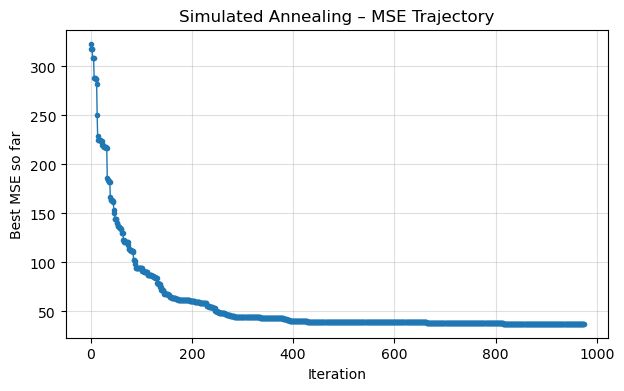

In [66]:
plt.figure(figsize=(7,4))
plt.plot(mse_traj[200:], marker='o', markersize=3, linewidth=1)
plt.xlabel("Iteration")
plt.ylabel("Best MSE so far")
plt.title("Simulated Annealing – MSE Trajectory")
plt.grid(True, alpha=0.4)
plt.show()

In [59]:
# Convert trajectory to a DataFrame
df = pd.DataFrame({"SA": mse_traj})

# Save to CSV
df.to_csv("mse_traj.csv", index=False)

print("Saved MSE trajectory to mse_traj.csv")

Saved MSE trajectory to mse_traj.csv
